In [ ]:
import os
import numpy as np
from random import randint
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
from sklearn.utils import shuffle
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Activation, Dense, Flatten, BatchNormalization, Conv2D, MaxPool2D, GlobalAveragePooling2D, Dropout, MaxPooling2D
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import AdamW, Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [ ]:
train_dir = '/content/drive/MyDrive/Intel_image_classifications/seg_train/seg_train'
valid_dir = '/content/drive/MyDrive/Intel_image_classifications/seg_test/seg_test'
test_dir = '/content/drive/MyDrive/Intel_image_classifications/seg_pred'

In [ ]:
from tensorflow.keras.applications import resnet_v2
# Training data
train_data = ImageDataGenerator(preprocessing_function=resnet_v2.preprocess_input).flow_from_directory(
    directory=train_dir,
    target_size=(224, 224),
    batch_size=32
)

# Validation data
valid_data = ImageDataGenerator(preprocessing_function=resnet_v2.preprocess_input).flow_from_directory(
    directory=valid_dir,
    target_size=(224, 224),
    batch_size=32
)

# Test data
test_data = ImageDataGenerator(preprocessing_function=resnet_v2.preprocess_input).flow_from_directory(
    directory=test_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode=None,  # No labels for test data
    shuffle=False     # Preserve order for evaluation
)


Found 14044 images belonging to 6 classes.
Found 3000 images belonging to 6 classes.
Found 7301 images belonging to 1 classes.


In [ ]:
def get_images(directory):
    Images = []
    Labels = []
    label = 0

    for labels in os.listdir(directory):
        if labels == 'glacier':
            label = 2
        elif labels == 'sea':
            label = 4
        elif labels == 'buildings':
            label = 0
        elif labels == 'forest':
            label = 1
        elif labels == 'street':
            label = 5
        elif labels == 'mountain':
            label = 3

        for image_file in os.listdir(directory+labels):
            image = cv2.imread(directory+labels+r'/'+image_file)
            image = cv2.resize(image,(224,224))
            Images.append(image)
            Labels.append(label)

    return shuffle(Images,Labels,random_state=42)

def get_classlabel(class_code):
    labels = {2:'glacier', 4:'sea', 0:'buildings', 1:'forest', 5:'street', 3:'mountain'}

    return labels[class_code]

In [ ]:
Images, Labels = get_images('/content/drive/MyDrive/Intel_image_classifications/seg_train/seg_train/')

Images = np.array(Images)
Labels = np.array(Labels)

In [ ]:
print("Shape of Images:",Images.shape)
print("Shape of Labels:",Labels.shape)

Shape of Images: (14044, 224, 224, 3)
Shape of Labels: (14044,)


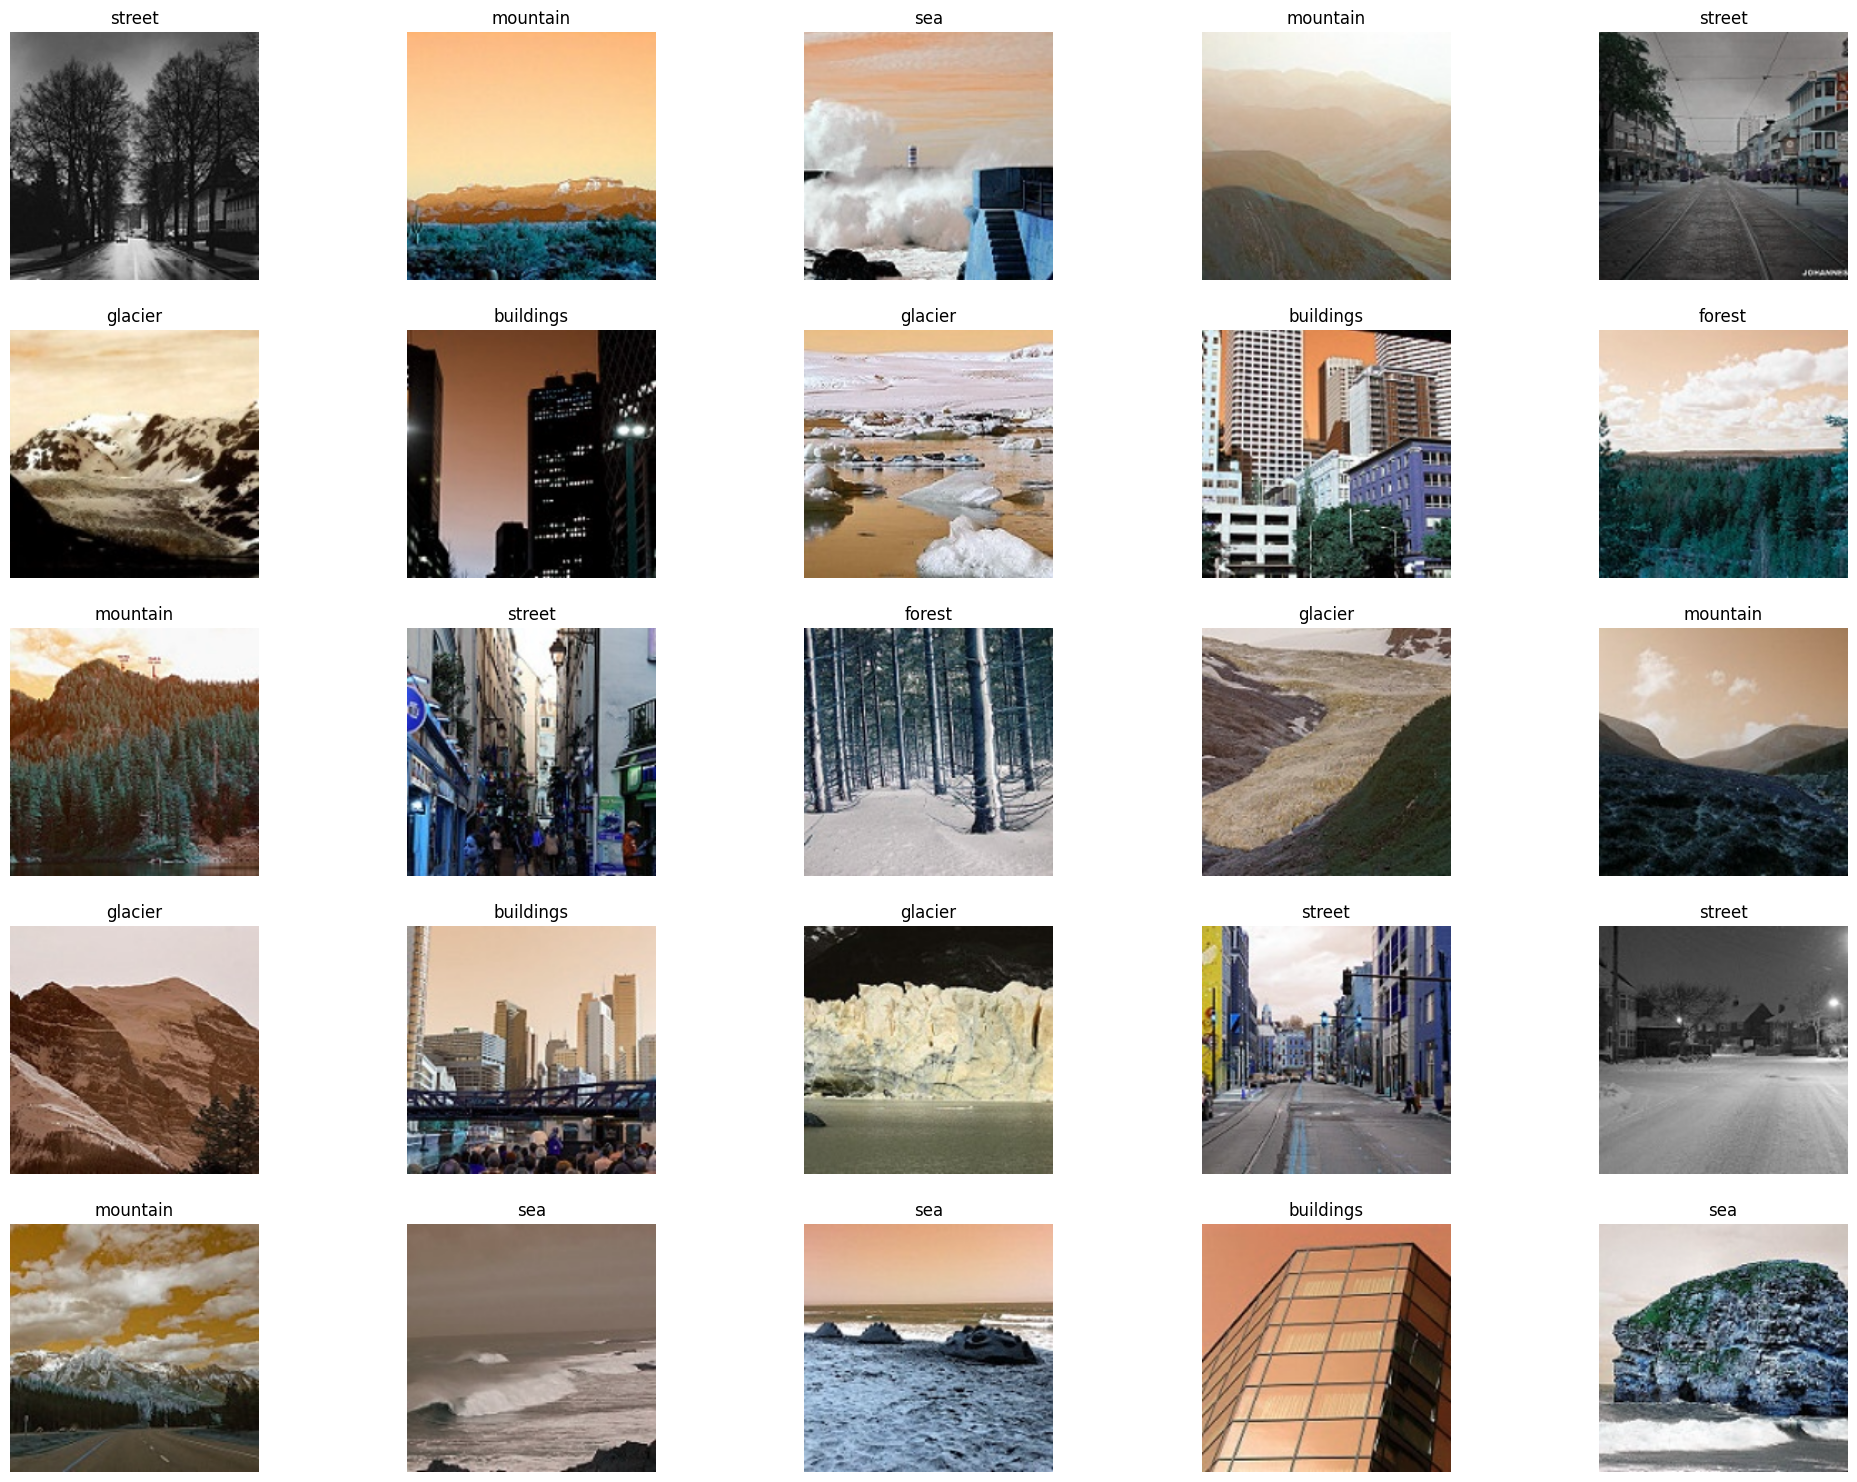

In [ ]:
f,ax = plt.subplots(5,5)
f.subplots_adjust(0,0,3,3)
for i in range(0,5,1):
    for j in range(0,5,1):
        rnd_number = randint(0,len(Images))
        ax[i,j].imshow(Images[rnd_number])
        ax[i,j].set_title(get_classlabel(Labels[rnd_number]))
        ax[i,j].axis('off')

<Axes: >

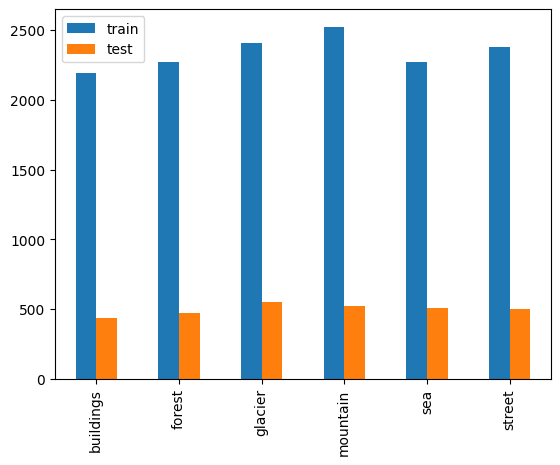

In [ ]:
class_label = list(train_data.class_indices.keys())
_, train_counts = np.unique(train_data.labels, return_counts=True)
_, test_counts = np.unique(valid_data.labels, return_counts=True)
pd.DataFrame({'train': train_counts,
                    'test': test_counts},
             index=class_label
            ).plot.bar()

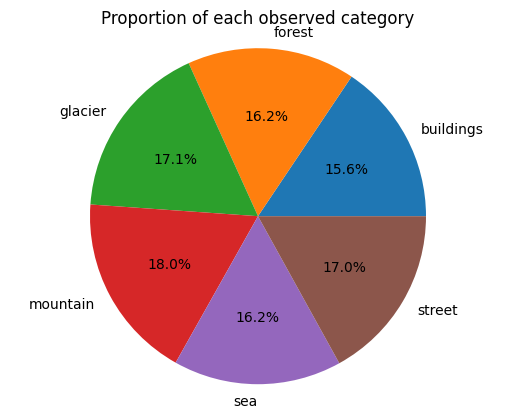

In [ ]:
plt.pie(train_counts,
        explode=(0, 0, 0, 0, 0, 0) ,
        labels=class_label,
        autopct='%1.1f%%')
plt.axis('equal')
plt.title('Proportion of each observed category')
plt.show()

In [ ]:
def create_model():
    model = Sequential([
        Conv2D(filters=128, kernel_size=(5, 5), padding='valid', input_shape=(224, 224, 3)),
        Activation('relu'),
        MaxPooling2D(pool_size=(2, 2)),
        BatchNormalization(),

        Conv2D(filters=64, kernel_size=(3, 3), padding='valid', kernel_regularizer=l2(0.00005)),
        Activation('relu'),
        MaxPooling2D(pool_size=(2, 2)),
        BatchNormalization(),

        Flatten(),

        Dense(units=256, activation='relu'),
        Dense(units=6, activation='softmax')
    ])

    return model

In [ ]:
strategy = tf.distribute.MirroredStrategy()

In [ ]:
with strategy.scope():
    Keras_base_model = create_model()

    Keras_base_model.compile(optimizer = Adam(learning_rate = 0.001), loss = 'categorical_crossentropy', metrics = ['accuracy'])

base_model_history = Keras_base_model.fit(x = train_data, validation_data = valid_data, epochs = 15)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/15
111/439 ━━━━━━━━━━━━━━━━━━━━ 1:05:57 12s/step - accuracy: 0.4430 - loss: 29.9484

In [ ]:
print('Accuracy of the model: {0}'.format(Keras_base_model.evaluate(valid_data)[1:][0]))

94/94 ━━━━━━━━━━━━━━━━━━━━ 14s 148ms/step - accuracy: 0.7204 - loss: 1.7485
Accuracy of the model: 0.718999981880188


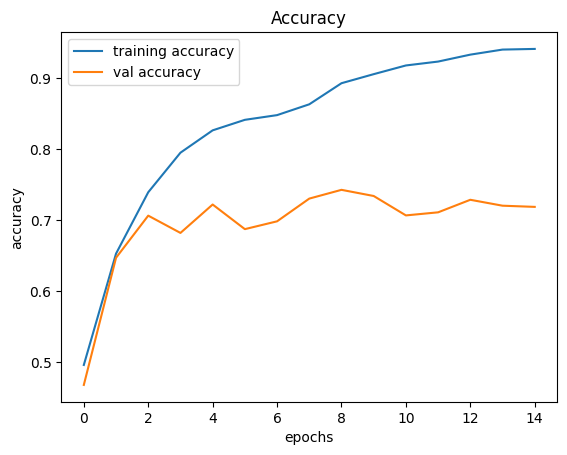

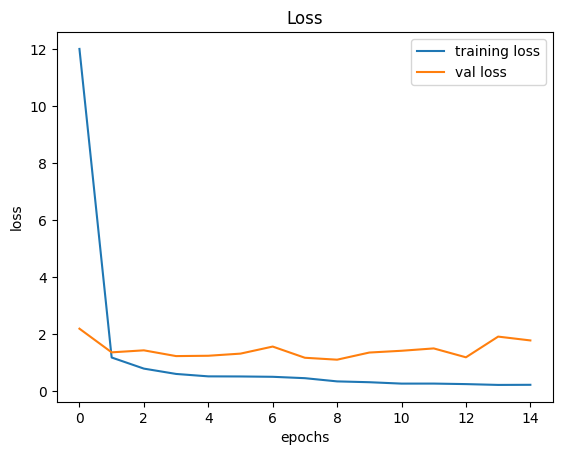

In [ ]:
plt.figure(0)
plt.plot(base_model_history.history['accuracy'], label='training accuracy')
plt.plot(base_model_history.history['val_accuracy'], label='val accuracy')
plt.title('Accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()

plt.figure(1)
plt.plot(base_model_history.history['loss'], label='training loss')
plt.plot(base_model_history.history['val_loss'], label='val loss')
plt.title('Loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 254ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


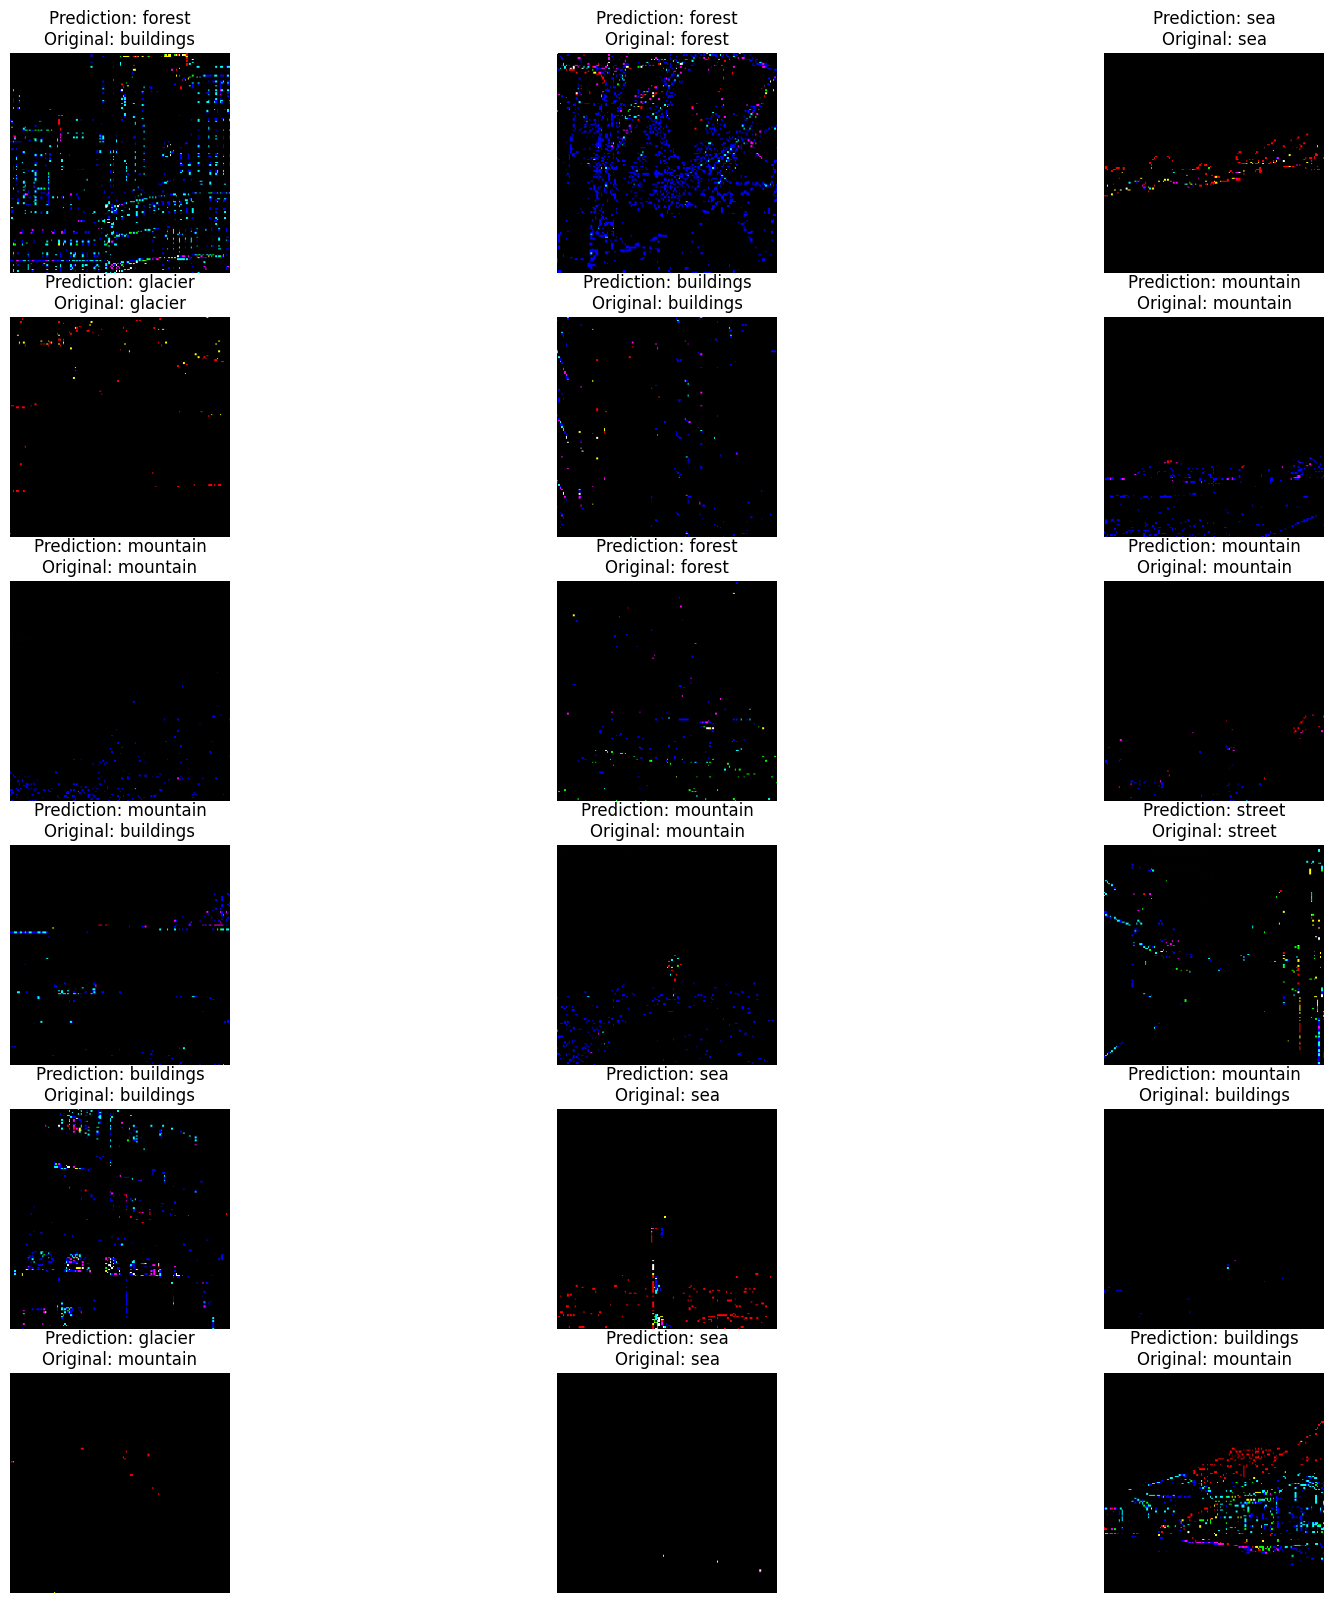

In [ ]:
import matplotlib.pyplot as plt
import tensorflow as tf

plt.figure(figsize=(20, 20))

# Get a batch of data from the generator
image, label = next(valid_data)  # Corrected from valid_data.next()

for i in range(18):
    # Make predictions for the batch
    model_pred = Keras_base_model.predict(image)

    # Plot each image and its predictions
    plt.subplot(6, 3, i + 1)
    plt.imshow(image[i].astype("uint8"))  # Ensure image is displayed correctly
    plt.title(
        f"Prediction: {class_label[tf.argmax(model_pred[i]).numpy()]}\n"
        f"Original: {class_label[tf.argmax(label[i]).numpy()]}"
    )
    plt.axis("off")

plt.show()